## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [75]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import warnings

!pip install uszipcode

     |████████████████████████████████| 454 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 3.5 MB/s eta 0:00:011
     |████████████████████████████████| 41 kB 3.0 MB/s eta 0:00:011
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.6.0
    Uninstalling pycodestyle-2.6.0:
      Successfully uninstalled pycodestyle-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 3.9.0 requires pyflakes<2.4.0,>=2.3.0, but you have pyflakes 2.2.0 which is incompatible.


In [ ]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [33]:
data= pd.read_csv("data/kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,NaN,0.00,3,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,NaN,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [107]:
# lets clean some DTypes
#cleaning Basement Sq feet

sqft_basement_list= []
for num in data['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))
data['sqft_basement']= sqft_basement_list
#cleaning year renovated        
data['yr_renovated'] = data['yr_renovated'].fillna(0).astype(int)
data['yr_renovated'] = np.where(data['yr_renovated'] == 0, data['yr_built'], data['yr_renovated'])

#corrected 33 bedroom house to 3
data['bedrooms'].replace(33, 3, inplace=True)

In [108]:
data['waterfront'].replace(np.nan, 0, inplace =True)

In [109]:
data['view'].replace(np.nan, 0 , inplace =True)

In [110]:
#check houses with same long and lat and getting rid of duplicate records

lat_long = {}
for a, b in zip(data['lat'].values, data['long'].values):
    if (a, b) not in list(lat_long.keys()):
        lat_long[(a, b)] = 1
    else:
        lat_long[(a, b)] += 1
for item in list(lat_long.keys()):
    if lat_long[item] < 2:
        del lat_long[item]
for item in list(lat_long.keys()):
        dfx = data[(data.lat == item[0]) & (data.long == item[1])]
        for id_d in dfx['id'].values:
            if dfx.loc[dfx['id'] == id_d]['yr_built'].values[0] != max(dfx['yr_built'].values):
                data = data.drop([data.loc[data['id'] == id_d].index[0]])

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21312 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21312 non-null  int64  
 1   date           21312 non-null  object 
 2   price          21312 non-null  float64
 3   bedrooms       21312 non-null  int64  
 4   bathrooms      21312 non-null  float64
 5   sqft_living    21312 non-null  int64  
 6   sqft_lot       21312 non-null  int64  
 7   floors         21312 non-null  float64
 8   waterfront     21312 non-null  float64
 9   view           21312 non-null  float64
 10  condition      21312 non-null  int64  
 11  grade          21312 non-null  int64  
 12  sqft_above     21312 non-null  int64  
 13  sqft_basement  20861 non-null  float64
 14  yr_built       21312 non-null  int64  
 15  yr_renovated   21312 non-null  int64  
 16  zipcode        21312 non-null  int64  
 17  lat            21312 non-null  float64
 18  long  

In [113]:

#Converting zipcode to city
# we are getting a look at the data per city 
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zip_lookup(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

data['City'] = data['zipcode'].apply(zip_lookup)

data["City"].value_counts()

Seattle          8792
Renton           1581
Bellevue         1396
Kent             1192
Kirkland          968
Redmond           967
Auburn            908
Sammamish         794
Federal Way       773
Issaquah          724
Maple Valley      582
Woodinville       470
Snoqualmie        307
Kenmore           280
Mercer Island     279
Enumclaw          231
North Bend        217
Bothell           195
Duvall            189
Carnation         122
Vashon            117
Black Diamond      99
Fall City          80
Medina             49
Name: City, dtype: int64

In [114]:
df_seattle = data[data['City'] == 'Seattle']

In [115]:
df_seattle.loc[df_seattle['price'].idxmin()]

id               40000362
date             5/6/2014
price            78000.00
bedrooms                2
bathrooms            1.00
sqft_living           780
sqft_lot            16344
floors               1.00
waterfront           0.00
view                 0.00
condition               1
grade                   5
sqft_above            780
sqft_basement        0.00
yr_built             1942
yr_renovated         1942
zipcode             98168
lat                 47.47
long              -122.28
sqft_living15        1700
sqft_lot15          10387
City              Seattle
Name: 15279, dtype: object

<AxesSubplot:xlabel='price', ylabel='Density'>

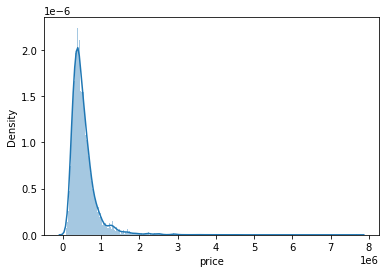

In [96]:
sns.distplot(a= df_seattle['price'], bins = 300)

In [138]:

data.loc[data["City"] == "Seattle", ["price"]]

,price
0,221900.00
1,538000.00
3,604000.00
7,291850.00
8,229500.00
...,...
21591,475000.00
21592,360000.00
21593,400000.00
21594,402101.00


In [146]:
cities = data['City']
Cities = cities.unique()

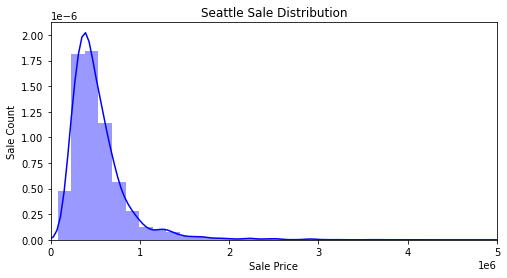

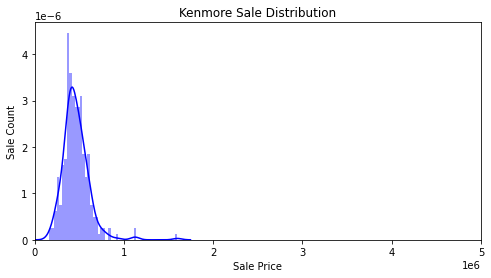

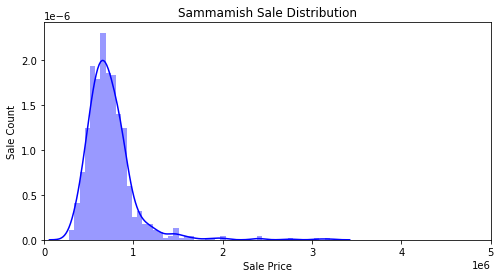

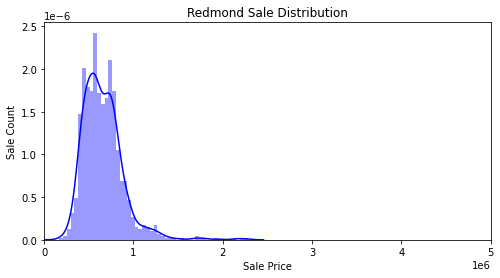

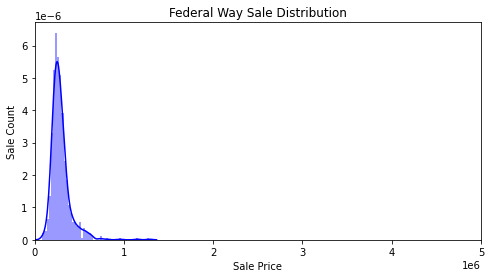

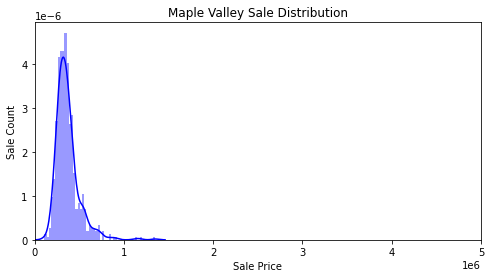

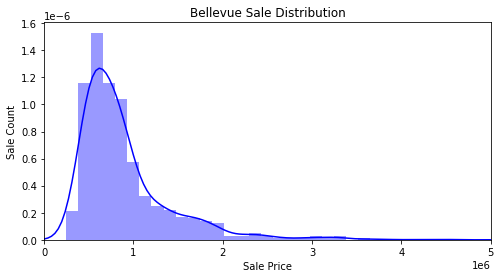

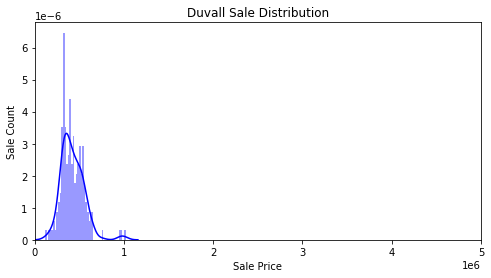

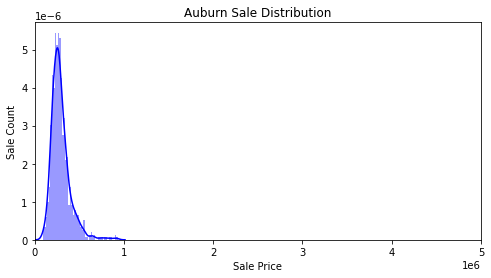

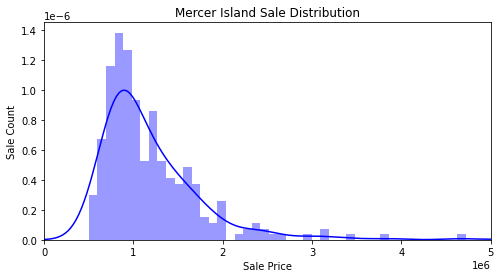

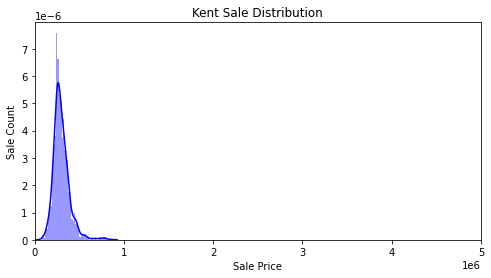

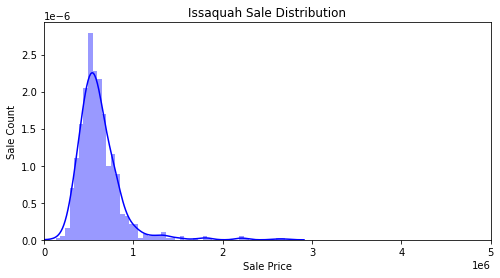

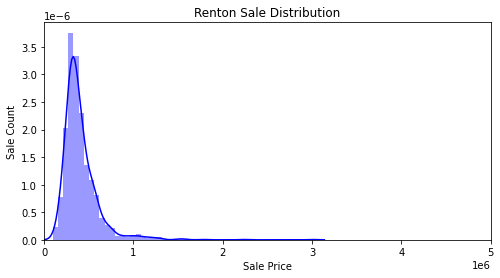

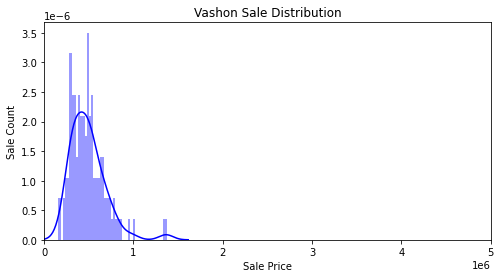

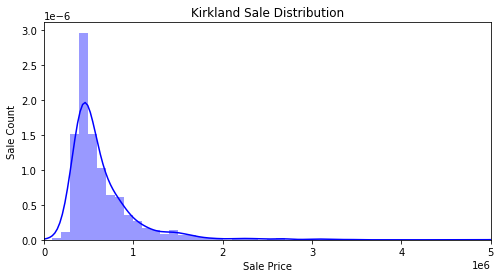

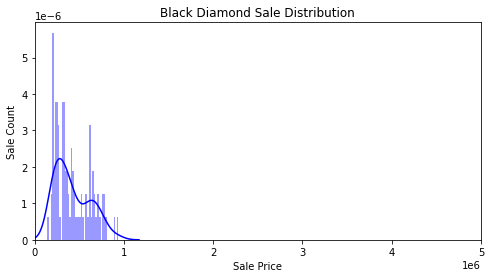

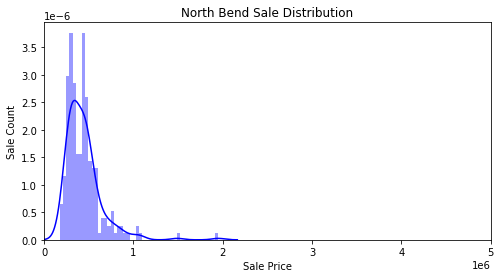

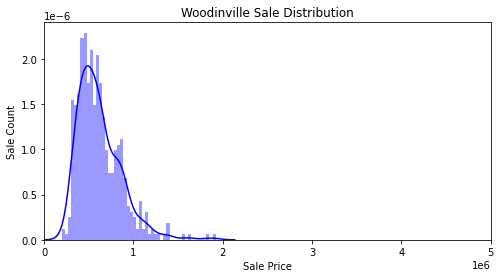

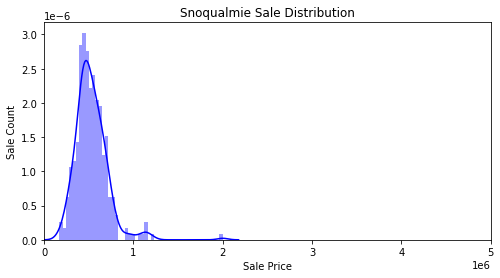

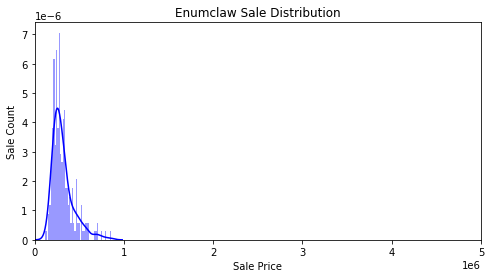

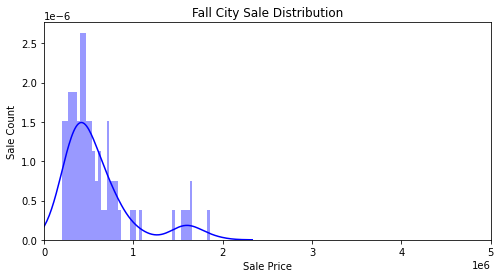

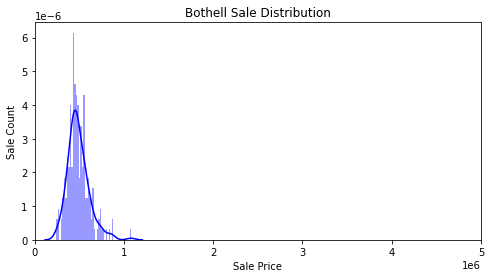

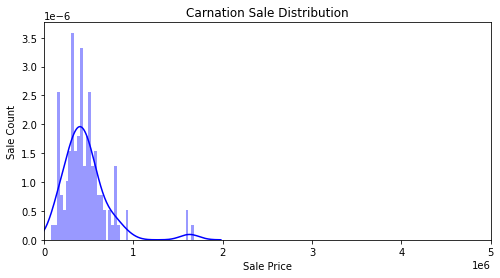

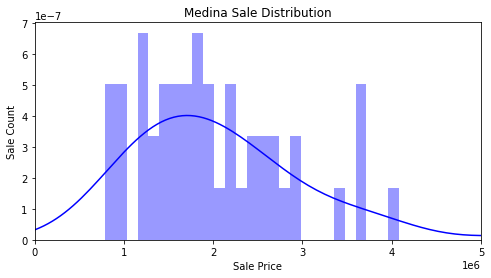

In [150]:


for city in Cities:
    
    fig, ax = plt.subplots(figsize = (8,4))
    sns.distplot(data.loc[data["City"] == city, ["price"]], bins=50, color = 'b')
    ax.set(xlim=[0, 5000000], xlabel='Sale Price', ylabel='Sale Count',
       title= f'{city} Sale Distribution')
    

In [159]:
mean_seattle = df_seattle['price'].mean()
mean_cities= []

In [160]:
for city in Cities:
    mean = data.loc[data["City"] == city, ["price"]].mean()
    print(city, mean)

Seattle price   535588.77
dtype: float64
Kenmore price   462740.54
dtype: float64
Sammamish price   732661.49
dtype: float64
Redmond price   658551.26
dtype: float64
Federal Way price   289635.99
dtype: float64
Maple Valley price   367852.13
dtype: float64
Bellevue price   899661.66
dtype: float64
Duvall price   425210.91
dtype: float64
Auburn price   291858.11
dtype: float64
Mercer Island price   1199537.51
dtype: float64
Kent price   299774.81
dtype: float64
Issaquah price   616349.17
dtype: float64
Renton price   404400.08
dtype: float64
Vashon price   489382.02
dtype: float64
Kirkland price   647613.47
dtype: float64
Black Diamond price   422187.87
dtype: float64
North Bend price   441351.31
dtype: float64
Woodinville price   617609.57
dtype: float64
Snoqualmie price   529882.65
dtype: float64
Enumclaw price   316250.98
dtype: float64
Fall City price   586120.88
dtype: float64
Bothell price   490377.11
dtype: float64
Carnation price   457760.02
dtype: float64
Medina price   2165612

In [164]:
control = np.array(df_seattle['price'])

In [176]:
Cities_no_seattle = Cities[1:]

#check to see which cities fall within the normal distribution with alpha level of 5%
for city in Cities_no_seattle:
    exp = np.array(data.loc[data["City"] == city]['price'])
    print(city, stats.ttest_ind(exp, control))
    
                

Kenmore Ttest_indResult(statistic=-3.558064537970104, pvalue=0.0003755056315598721)
Sammamish Ttest_indResult(statistic=15.784048965160062, pvalue=1.9930613694246708e-55)
Redmond Ttest_indResult(statistic=10.922052323525929, pvalue=1.3061998156185112e-27)
Federal Way Ttest_indResult(statistic=-19.932464896738697, pvalue=1.2046065055019629e-86)
Maple Valley Ttest_indResult(statistic=-11.788587449726565, pvalue=7.499262884763621e-32)
Bellevue Ttest_indResult(statistic=33.32547302477232, pvalue=3.188265203116826e-231)
Duvall Ttest_indResult(statistic=-4.43582247890187, pvalue=9.281374324402197e-06)
Auburn Ttest_indResult(statistic=-21.391828743906526, pvalue=3.0556555986423976e-99)
Mercer Island Ttest_indResult(statistic=30.94975692115126, pvalue=4.987318226237502e-200)
Kent Ttest_indResult(statistic=-23.721477999370023, pvalue=4.647421674340823e-121)
Issaquah Ttest_indResult(statistic=6.214561926527218, pvalue=5.36270143406931e-10)
Renton Ttest_indResult(statistic=-14.817266289985675, pv

In [199]:
# given alpha level of .05 we have decided to drop towns that were statistically different than Seattle given the data
dropped_cities= ["Vashon", "Snoqualmie", "Fall City", "Bothell"]

df_clean_city= data[~data['City'].isin(dropped_cities)]





0.00    18618
2.00      905
3.00      474
1.00      320
4.00      296
Name: view, dtype: int64

In [205]:
# lets look at the heatmap and corr
df_clean_city.corr()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,-0.00,-0.01,-0.02,-0.13,0.00,0.01,0.01,-0.02,0.00,-0.03,0.00,0.01,0.01,-0.01,-0.00,-0.01,-0.02,-0.13
price,-0.02,1.00,0.32,0.53,0.70,0.08,0.26,0.29,0.40,0.04,0.67,0.61,0.33,0.05,0.10,-0.06,0.31,0.02,0.59,0.08
bedrooms,-0.00,0.32,1.00,0.53,0.59,0.05,0.18,0.02,0.09,0.03,0.37,0.49,0.31,0.16,0.17,-0.16,-0.02,0.13,0.40,0.05
bathrooms,-0.01,0.53,0.53,1.00,0.75,0.09,0.50,0.08,0.19,-0.12,0.66,0.68,0.29,0.50,0.53,-0.20,0.03,0.22,0.57,0.10
sqft_living,-0.02,0.70,0.59,0.75,1.00,0.18,0.35,0.12,0.29,-0.05,0.76,0.87,0.44,0.31,0.33,-0.20,0.05,0.24,0.75,0.19
sqft_lot,-0.13,0.08,0.05,0.09,0.18,1.00,-0.01,0.01,0.07,-0.01,0.12,0.19,0.02,0.05,0.05,-0.13,-0.08,0.27,0.16,0.72
floors,0.00,0.26,0.18,0.50,0.35,-0.01,1.00,0.03,0.03,-0.26,0.46,0.52,-0.24,0.49,0.50,-0.06,0.05,0.11,0.27,-0.01
waterfront,0.01,0.29,0.02,0.08,0.12,0.01,0.03,1.00,0.37,0.01,0.10,0.09,0.09,-0.02,-0.00,0.03,0.00,-0.02,0.10,0.02
view,0.01,0.40,0.09,0.19,0.29,0.07,0.03,0.37,1.00,0.05,0.25,0.17,0.28,-0.06,-0.03,0.09,0.02,-0.08,0.29,0.07
condition,-0.02,0.04,0.03,-0.12,-0.05,-0.01,-0.26,0.01,0.05,1.00,-0.15,-0.15,0.17,-0.36,-0.39,-0.00,-0.01,-0.09,-0.08,-0.01


In [216]:
#dropping non useful feature for our baseline regression
df_initial_r = df_clean_city.drop(['id', 'date', 'zipcode','price' ], axis=1)
Y= df_clean_city['price']

In [222]:
#scale our variables 
df_scaled_initial = (df_initial_r-np.mean(df_initial_r))/np.std(df_initial_r)

ss= StandardScaler()
ss.fit(df_initial_r.drop("City", axis=1))

StandardScaler()

In [220]:
df_scaled_initial

,City,bathrooms,bedrooms,condition,floors,grade,lat,long,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated
0,NaN,-1.45,-0.41,-0.64,-0.90,-0.56,-0.34,-0.29,-0.73,-0.67,-0.98,-0.94,-0.23,-0.26,-0.30,-0.08,-0.54,-0.62
1,NaN,0.18,-0.41,-0.64,0.94,-0.56,1.16,-0.75,0.47,0.23,0.54,-0.42,-0.19,-0.18,-0.30,-0.08,-0.68,0.63
2,NaN,-1.45,-1.52,-0.64,-0.90,-1.41,1.28,-0.11,-1.22,-0.67,-1.42,1.08,-0.11,-0.16,-0.30,-0.08,-1.29,-1.38
3,NaN,1.15,0.69,2.43,-0.90,-0.56,-0.27,-1.30,-0.88,1.38,-0.13,-0.91,-0.24,-0.28,-0.30,-0.08,-0.20,-0.27
4,NaN,-0.15,-0.41,-0.64,-0.90,0.29,0.41,1.30,-0.12,-0.67,-0.43,-0.26,-0.16,-0.19,-0.30,-0.08,0.55,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,NaN,0.50,-0.41,-0.64,2.79,0.29,1.01,-0.95,-0.30,-0.67,-0.60,-0.66,-0.34,-0.42,-0.30,-0.08,1.31,1.26
21593,NaN,0.50,0.69,-0.64,0.94,0.29,-0.35,-1.07,0.64,-0.67,0.25,-0.22,-0.22,-0.20,-0.30,-0.08,1.48,1.43
21594,NaN,-1.77,-1.52,-0.64,0.94,-0.56,0.25,-0.60,-0.92,-0.67,-1.15,-1.41,-0.34,-0.40,-0.30,-0.08,1.31,1.26
21595,NaN,0.50,-0.41,-0.64,0.94,0.29,-0.18,1.12,-0.22,-0.67,-0.52,-0.83,-0.31,-0.43,-0.30,-0.08,1.14,1.09


In [226]:
# df_scaled2=ss.transform(df_initial_r.drop("City", axis=1))

In [236]:
# df_scaled2
df_scaled_initial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20613 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           0 non-null      object 
 1   bathrooms      20613 non-null  float64
 2   bedrooms       20613 non-null  float64
 3   condition      20613 non-null  float64
 4   floors         20613 non-null  float64
 5   grade          20613 non-null  float64
 6   lat            20613 non-null  float64
 7   long           20613 non-null  float64
 8   sqft_above     20613 non-null  float64
 9   sqft_basement  20173 non-null  float64
 10  sqft_living    20613 non-null  float64
 11  sqft_living15  20613 non-null  float64
 12  sqft_lot       20613 non-null  float64
 13  sqft_lot15     20613 non-null  float64
 14  view           20613 non-null  float64
 15  waterfront     20613 non-null  float64
 16  yr_built       20613 non-null  float64
 17  yr_renovated   20613 non-null  float64
dtypes: flo

In [243]:
df_scaled_initial['sqft_basement'].fillna(0, inplace= True)

In [244]:

model = sm.OLS(Y, sm.add_constant(df_scaled_initial.drop("City", axis= 1))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2871.
Date:                Mon, 12 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:23:26   Log-Likelihood:            -2.8115e+05
No. Observations:               20613   AIC:                         5.623e+05
Df Residuals:                   20595   BIC:                         5.625e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.416e+05   1414.025    383.008      0.000    5.39e+05    5.44e+05
bathrooms      3.493e+04   2593.795     13.469      0.000    2.99e+04       4e+04
bedrooms      -3.526e+04   1843.191    -19.128      0.000   -3.89e+04   -3.16e+04
condition      2.056e+04   1573.227     13.068      0.000    1.75e+04    2.36e+04
floors         -908.9774   2000.584     -0.454      0.650   -4830.280    3012.325
grade          1.132e+05   2636.436     42.955      0.000    1.08e+05    1.18e+05
lat            7.912e+04   1501.734     52.689      0.000    7.62e+04    8.21e+04
long          -1.634e+04   1759.401     -9.289      0.000   -1.98e+04   -1.29e+04
sqft_above     8.119e+04   1.79e+04      4.538      0.000    4.61e+04    1.16e+05
sqft_basement  2.842e+04   9628.908      2.952      0.003    9547.520    4.73e+04
sqft_living    7.828e+04   1.99e+04      3.937      0.000    3.93e+04    1.17e+05
sqft_living15  2.037e+04   2425.051      8.399      0.000    1.56e+04    2.51e+04
sqft_lot       2528.7358   2042.085      1.238      0.216   -1473.913    6531.385
sqft_lot15    -1.121e+04   2067.793     -5.419      0.000   -1.53e+04   -7153.167
view           3.963e+04   1665.857     23.788      0.000    3.64e+04    4.29e+04
waterfront     5.505e+04   1526.069     36.075      0.000    5.21e+04     5.8e+04
yr_built      -9.451e+04   3862.444    -24.468      0.000   -1.02e+05   -8.69e+04
yr_renovated   2.244e+04   3914.456      5.733      0.000    1.48e+04    3.01e+04
==============================================================================
Omnibus:                    17380.077   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1674366.125
Skew:                           3.531   Prob(JB):                         0.00
Kurtosis:                      46.584   Cond. No.                         46.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [246]:
df_clean_city.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,-0.00,-0.01,-0.02,-0.13,0.00,0.01,0.01,-0.02,0.00,-0.03,0.00,0.01,0.01,-0.01,-0.00,-0.01,-0.02,-0.13
price,-0.02,1.00,0.32,0.53,0.70,0.08,0.26,0.29,0.40,0.04,0.67,0.61,0.33,0.05,0.10,-0.06,0.31,0.02,0.59,0.08
bedrooms,-0.00,0.32,1.00,0.53,0.59,0.05,0.18,0.02,0.09,0.03,0.37,0.49,0.31,0.16,0.17,-0.16,-0.02,0.13,0.40,0.05
bathrooms,-0.01,0.53,0.53,1.00,0.75,0.09,0.50,0.08,0.19,-0.12,0.66,0.68,0.29,0.50,0.53,-0.20,0.03,0.22,0.57,0.10
sqft_living,-0.02,0.70,0.59,0.75,1.00,0.18,0.35,0.12,0.29,-0.05,0.76,0.87,0.44,0.31,0.33,-0.20,0.05,0.24,0.75,0.19
sqft_lot,-0.13,0.08,0.05,0.09,0.18,1.00,-0.01,0.01,0.07,-0.01,0.12,0.19,0.02,0.05,0.05,-0.13,-0.08,0.27,0.16,0.72
floors,0.00,0.26,0.18,0.50,0.35,-0.01,1.00,0.03,0.03,-0.26,0.46,0.52,-0.24,0.49,0.50,-0.06,0.05,0.11,0.27,-0.01
waterfront,0.01,0.29,0.02,0.08,0.12,0.01,0.03,1.00,0.37,0.01,0.10,0.09,0.09,-0.02,-0.00,0.03,0.00,-0.02,0.10,0.02
view,0.01,0.40,0.09,0.19,0.29,0.07,0.03,0.37,1.00,0.05,0.25,0.17,0.28,-0.06,-0.03,0.09,0.02,-0.08,0.29,0.07
condition,-0.02,0.04,0.03,-0.12,-0.05,-0.01,-0.26,0.01,0.05,1.00,-0.15,-0.15,0.17,-0.36,-0.39,-0.00,-0.01,-0.09,-0.08,-0.01


In [266]:
df_clean_city['bath_cond']= df_clean_city['bathrooms']*df_clean_city['condition']
df_clean_city['sqALL']= df_clean_city['sqft_living']*df_clean_city['yr_renovated']
df_clean_city['sqCOND']= df_clean_city['waterfront']*df_clean_city['bathrooms']
df_clean_city.corr()['price']

id              -0.02
price            1.00
bedrooms         0.32
bathrooms        0.53
sqft_living      0.70
sqft_lot         0.08
floors           0.26
waterfront       0.29
view             0.40
condition        0.04
grade            0.67
sqft_above       0.61
sqft_basement    0.33
yr_built         0.05
yr_renovated     0.10
zipcode         -0.06
lat              0.31
long             0.02
sqft_living15    0.59
sqft_lot15       0.08
bath_cond        0.51
view_floor       0.43
floor_bed        0.38
sqALL            0.70
sqCOND           0.32
Name: price, dtype: float64

In [ ]:
# RFE